# CS 424 - Final Project <br>
 <a href="https://colab.research.google.com/github/jacksoneshbaugh/CS-424-Final-Project/blob/master/Final_Project_Mazza_Eshbaugh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




This project is a financial budgeting tool. It first focuses on applying an **isolation forest model** for **anomaly detection** to determine purchases that are higher than usual. It also utilizes a **Long Short-Term Memory (LSTM)** neural network for **time series forecasting** to predict future spending habits. It also includes **Natural Language Processing** features such as unique recommendations and a chatbot using **Google's Gemma 2 2B-it Large Language Model (LLM)** via Hugging Face.


## Before Running the Notebook
Since Google's Gemma 2 LLM is a gated model, please do the following to gain access prior to running the notebook:
1. Go to [https://huggingface.co/google/gemma-2-2b-it](https://huggingface.co/google/gemma-2-2b-it) and click "Access repository".
2. Go to [https://huggingface.co/settings/tokens](https://huggingface.co/settings/tokens) and create a token with **read access**.
3. Paste this token when prompted in the notebook.


In [ ]:
!pip install kagglehub[hf-datasets]

In [ ]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("Is GPU available?", tf.config.list_physical_devices('GPU'))

TF version: 2.18.0
Is GPU available? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Uploading Your Data into the System

The system requires some personal financial data. When you upload it, you consent to inputting the data into our models. Our system requires:

1. **Transactions CSV** — This could be a bank statement or a credit card statement. It should be in CSV format, and have the following columns:
  - `date` — date of the transaction
  - `amount` — transaction amount
  - `category` — how the transaction is categorized

Hence, the full CSV should resemble:

| date | category |amount |
|------|----------|-----|
| 07/13/2004 | dining out | $100.34 |
| ... | ... | ... |

2. **Weekly Income** — To assist our model in providing some helpful advice, you should enter your income per week (even if it is not disbursed per week).

In [ ]:
from google.colab import files
import pandas as pd

# Upload file
print("Please upload your Transactions CSV file:")
uploaded = files.upload()

# Get uploaded filename
if len(uploaded) != 1:
    raise ValueError("Please upload exactly one CSV file.")

filename = next(iter(uploaded))

# Load CSV
try:
    user_df = pd.read_csv(filename)
except Exception as e:
    raise ValueError(f"Failed to read CSV: {e}")

# Check required columns
required_cols = {'date', 'amount', 'category'}
actual_cols = set(user_df.columns.str.lower())

if not required_cols.issubset(actual_cols):
    raise ValueError(f"CSV must include the following columns: {required_cols}. Found: {user_df.columns.tolist()}")

# Show a sample
print("Transactions file loaded successfully. Here's a preview:")
display(user_df.head())

# Validate data types
user_df['date'] = pd.to_datetime(user_df['date'], errors='coerce')
user_df['amount'] = user_df['amount'].replace('[\$,]', '', regex=True).astype(float)

if user_df['date'].isnull().any():
    raise ValueError("Some dates could not be parsed. Check your 'date' column formatting.")

# Prompt for weekly income
user_income_weekly = 700  # @param {"type":"number","placeholder":"e.g. 175"}

if user_income_weekly <= 0:
    raise ValueError("Please provide a valid weekly income (greater than 0).")

print(f"Weekly income set to: ${user_income_weekly}")

Please upload your Transactions CSV file:


Saving sample_transactions.csv to sample_transactions.csv
Transactions file loaded successfully. Here's a preview:


,date,category,amount
0,02/11/2025,health,$100.25
1,02/11/2025,groceries,$16.47
2,02/12/2025,groceries,$26.13
3,02/12/2025,health,$61.35
4,02/12/2025,dining out,$15.39


Weekly income set to: $700


In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "11 march 2025.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "ismetsemedov/personal-budget-transactions-dataset",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

# Convert the 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows where date conversion failed if any
df = df.dropna(subset=['date'])

print("First 5 records:", df.head())

<ipython-input-4-1da7b30583c9>:10: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 172k/172k [00:00<00:00, 897kB/s]


First 5 records:                        date    category  amount
0 2022-07-06 05:57:10+00:00  Restuarant    5.50
1 2022-07-06 05:57:27+00:00      Market    2.00
2 2022-07-06 05:58:12+00:00       Coffe   30.10
3 2022-07-06 05:58:25+00:00      Market   17.33
4 2022-07-06 05:59:00+00:00  Restuarant    5.50


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

user_df.columns = user_df.columns.str.lower()
original_user_df = user_df.copy()

# Standardize column names
user_df['date'] = pd.to_datetime(user_df['date'], errors='coerce')
user_df['amount'] = user_df['amount'].replace('[\$,]', '', regex=True).astype(float)

# Drop rows with missing or invalid data
user_df = user_df.dropna(subset=['date', 'amount', 'category'])

# One-hot encode categories
user_df = pd.get_dummies(user_df, columns=['category'], prefix='category')

# Select features for anomaly detection
features = ['amount'] + [col for col in user_df.columns if col.startswith('category_')]
X = user_df[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run Isolation Forest
anomaly_model = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
anomaly_model.fit(X_scaled)

user_df['anomaly_score'] = anomaly_model.decision_function(X_scaled)
user_df['anomaly'] = anomaly_model.predict(X_scaled)

# Extract and display anomalies
anomalies = user_df[user_df['anomaly'] == -1]
print(f"Found {len(anomalies)} anomalies:")
display(anomalies[['date', 'amount', 'anomaly_score'] + [c for c in user_df.columns if c.startswith('category_')]])

Found 52 anomalies:


,date,amount,anomaly_score,category_dining out,category_entertainment,category_groceries,category_health,category_misc,category_transportation,category_utilities
0,2025-02-11,100.25,-0.014158,False,False,False,True,False,False,False
5,2025-02-12,8.20,-0.004437,False,False,False,False,False,True,False
8,2025-02-13,111.20,-0.027862,False,False,False,True,False,False,False
11,2025-02-14,87.06,-0.012378,False,False,False,True,False,False,False
12,2025-02-14,70.12,-0.036138,False,True,False,False,False,False,False
14,2025-02-15,94.23,-0.116467,False,True,False,False,False,False,False
17,2025-02-17,95.57,-0.032532,False,False,True,False,False,False,False
21,2025-02-19,27.28,-0.000571,False,True,False,False,False,False,False
22,2025-02-19,73.15,-0.034955,False,True,False,False,False,False,False
23,2025-02-19,83.85,-0.005892,False,False,True,False,False,False,False


## Reframing the Problem: From Per-Category to Total Weekly Spending

### Initial Approach
Our original model attempted to predict future spending per category using an LSTM architecture. We treated each category as a separate time series and embedded categorical features alongside the scaled amount values. However, despite achieving a low numerical MSE (≈0.0031), our model failed to produce meaningful predictions — it tended to output nearly constant values, failing to capture temporal variation.

We diagnosed the issue as **underfitting**, largely due to:
- **Short, sparse, and noisy sequences** per category
- **Low signal-to-noise ratio** in the target values
- Difficulty in generalizing from such fragmented data

### Pivoting to a Simpler, Stronger Signal
To address these challenges, we reframed the problem: instead of predicting spending per category, we chose to model **total weekly spending**.

This change:
- Produced a **longer, continuous, and denser** sequence of values
- Removed the need for label encoding or embeddings
- Resulted in a more learnable signal with smoother trends

### Final Model
We trained a single-layer LSTM on the normalized total spending sequence with a look-back window of 12 weeks. Our model achieved meaningful validation performance and, for the first time, **captured actual trends** in spending.

## Time-Series: Predicting Weekly Expenditures

Firstly, we group the data by week, in order to feed our LSTM model clear week-by-week data.

In [ ]:
df['week'] = df['date'].dt.to_period('W')
weekly_df = df.groupby('week')['amount'].sum().reset_index()
weekly_df['week'] = weekly_df['week'].dt.to_timestamp()

print(weekly_df.head())

        week   amount
0 2022-07-04   280.83
1 2022-07-11   302.92
2 2022-07-18   101.28
3 2022-07-25  2176.35
4 2022-08-01   199.97


<ipython-input-6-24b7a8be7012>:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['week'] = df['date'].dt.to_period('W')


### Preprocessing the Data

At this point, we now preprocess the data. Firstly, we scale the data using a `MinMaxScaler` from `sklearn`. We define a function `create_sequences` to create data sequences for an arbitrary number of weeks to look back to (`look_back`). Finally we split the data into three sets.

| Training | Validation | Testing |
|----------|------------|---------|
|   70%    |     15%    |   15%   |

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

# Scale
scaler = MinMaxScaler()
weekly_df['amount_scaled'] = scaler.fit_transform(weekly_df[['amount']])

# Create sequences for LSTM
def create_sequences(series, look_back=12):
    X, Y = [], []
    for i in range(look_back, len(series)):
        X.append(series[i-look_back:i])
        Y.append(series[i])
    return np.array(X), np.array(Y)

look_back = 12
X, Y = create_sequences(weekly_df['amount_scaled'].values, look_back)

# Train/val/test split
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:train_size+val_size], Y[train_size:train_size+val_size]
X_test, Y_test = X[train_size+val_size:], Y[train_size+val_size:]

X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.float32)
X_val = X_val.astype(np.float32)
Y_val = Y_val.astype(np.float32)
X_test = X_test.astype(np.float32)
Y_test = Y_test.astype(np.float32)

### Hyperparameter Tuning

We selected a set of manually-tuned hyperparameter configurations to explore the effects of sequence length, model capacity, regularization, and optimizer settings on LSTM performance. Each configuration was trained using early stopping (patience = 10), and evaluated using validation MSE.

| Config | Look-back | LSTM Units      | Layers  | Batch Size | Learning Rate | Dropout | Notes |
|--------|-----------|------------------|---------|------------|----------------|---------|-------|
| 1      | 12        | 64               | 1 LSTM  | 32         | 0.001          | —       | Baseline; no dropout |
| 2      | 12        | 128              | 1 LSTM  | 32         | 0.001          | 0.2     | Higher capacity + regularization |
| 3      | 6         | 64               | 1 LSTM  | 16         | 0.0005         | 0.2     | Smaller look-back, lower learning rate |
| 4      | 18        | 128              | 1 LSTM  | 64         | 0.0005         | 0.3     | Long memory + strong regularization |
| 5      | 12        | 32               | 1 LSTM  | 32         | 0.001          | —       | Lightweight, fast to train |
| 6      | 12        | 64               | 1 LSTM  | 64         | 0.0005         | 0.2     | Balanced config with larger batch |
| 7      | 12        | 128 → 64         | 2 LSTM  | 32         | 0.001          | 0.2     | Stacked LSTMs for deeper modeling |

To test each of these configs, we define `run_config`, a function that trains and plots each configuration (training and validation sets).

We record validation and test losses for each configuration, alongside training epochs and prediction quality to determine the best balance between complexity and performance.

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

def run_config(X_train, Y_train, X_val, Y_val,
               look_back, lstm_units, layers, batch_size, lr, dropout, config_name):

    input_shape = (look_back, 1)

    model = Sequential()
    if layers == 1:
        model.add(LSTM(lstm_units, activation='tanh', recurrent_activation='sigmoid', input_shape=input_shape))
        if dropout > 0:
            model.add(Dropout(dropout))
    elif layers == 2:
        model.add(LSTM(lstm_units[0], activation='tanh', recurrent_activation='sigmoid', return_sequences=True, input_shape=input_shape))
        if dropout > 0:
            model.add(Dropout(dropout))
        model.add(LSTM(lstm_units[1], activation='tanh', recurrent_activation='sigmoid'))
        if dropout > 0:
            model.add(Dropout(dropout))
    else:
        raise ValueError("Unsupported number of LSTM layers")

    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, Y_train,
                        validation_data=(X_val, Y_val),
                        epochs=50,
                        batch_size=batch_size,
                        callbacks=[early_stop],
                        verbose=0)

    val_loss = model.evaluate(X_val, Y_val, verbose=0)
    print(f"{config_name} — Val MSE: {val_loss:.4f}")

    # Plot learning curve
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{config_name} — Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Config #1 — Val MSE: 0.0231


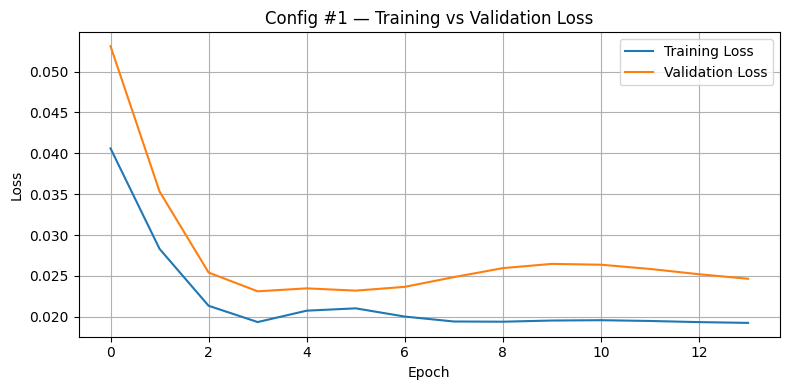

Config #2 — Val MSE: 0.0234


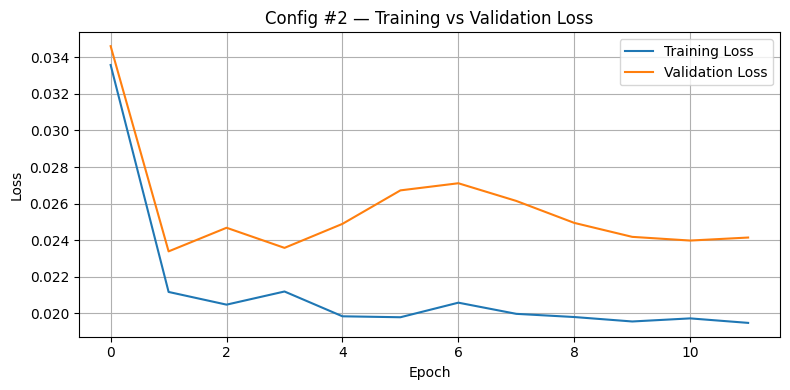

Config #3 — Val MSE: 0.0239


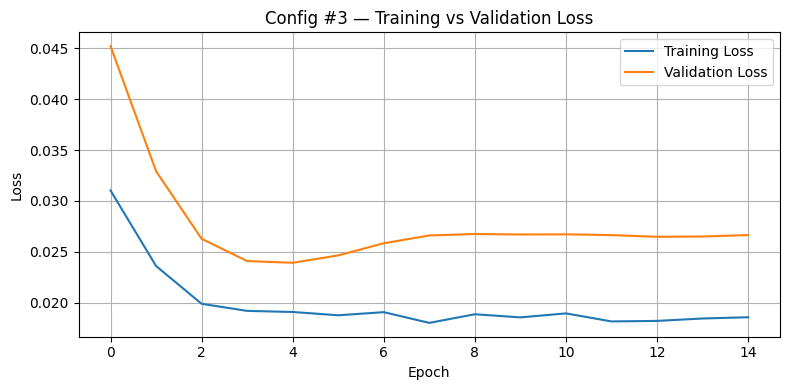

Config #4 — Val MSE: 0.0241


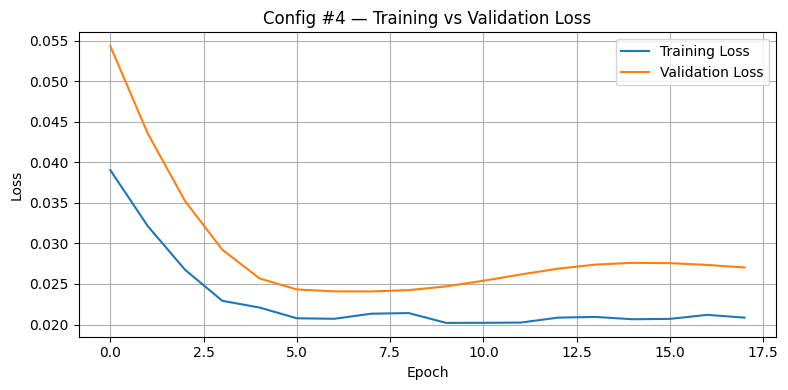

Config #5 — Val MSE: 0.0239


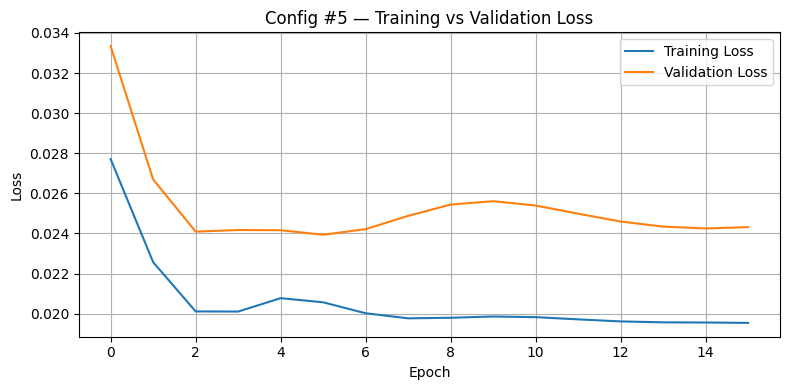

Config #6 — Val MSE: 0.0234


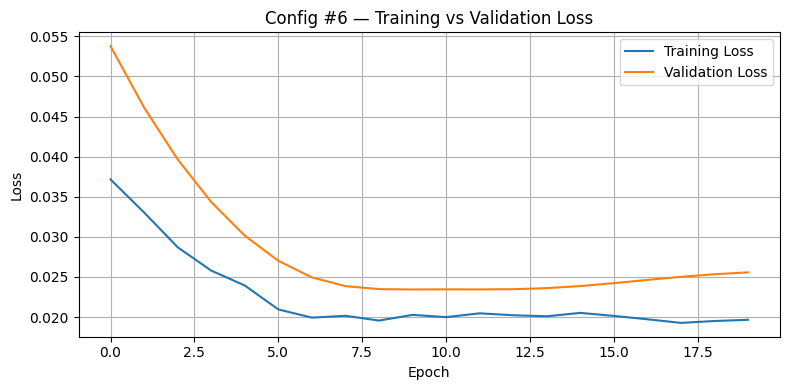

Config #7 — Val MSE: 0.0234


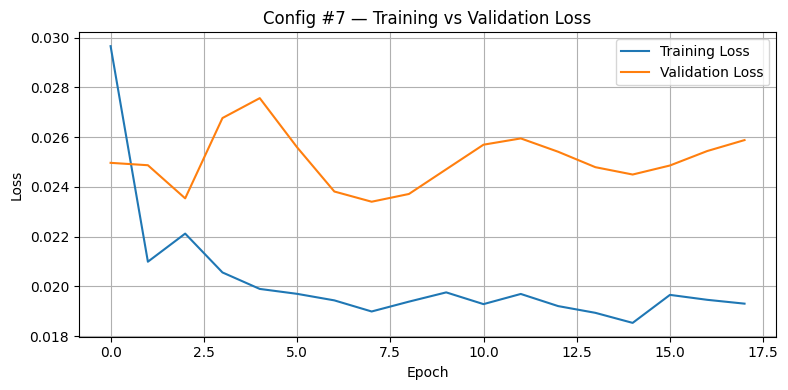

In [ ]:
def create_lstm_dataset(series, look_back):
    X, Y = [], []
    for i in range(look_back, len(series)):
        X.append(series[i-look_back:i])
        Y.append(series[i])
    X = np.array(X)[..., np.newaxis]
    Y = np.array(Y)
    return X, Y

configs = [
    {"name": "Config #1", "look_back": 12, "lstm_units": 64, "layers": 1, "batch_size": 32, "lr": 0.001, "dropout": 0.0},
    {"name": "Config #2", "look_back": 12, "lstm_units": 128, "layers": 1, "batch_size": 32, "lr": 0.001, "dropout": 0.2},
    {"name": "Config #3", "look_back": 6,  "lstm_units": 64, "layers": 1, "batch_size": 16, "lr": 0.0005, "dropout": 0.2},
    {"name": "Config #4", "look_back": 18, "lstm_units": 128, "layers": 1, "batch_size": 64, "lr": 0.0005, "dropout": 0.3},
    {"name": "Config #5", "look_back": 12, "lstm_units": 32, "layers": 1, "batch_size": 32, "lr": 0.001, "dropout": 0.0},
    {"name": "Config #6", "look_back": 12, "lstm_units": 64, "layers": 1, "batch_size": 64, "lr": 0.0005, "dropout": 0.2},
    {"name": "Config #7", "look_back": 12, "lstm_units": [128, 64], "layers": 2, "batch_size": 32, "lr": 0.001, "dropout": 0.2},
]

for cfg in configs:
    series = weekly_df['amount_scaled'].values
    X_all, Y_all = create_lstm_dataset(series, cfg["look_back"])

    train_size = int(len(X_all) * 0.7)
    val_size = int(len(X_all) * 0.15)

    X_train = X_all[:train_size]
    Y_train = Y_all[:train_size]
    X_val = X_all[train_size:train_size + val_size]
    Y_val = Y_all[train_size:train_size + val_size]

    run_config(X_train, Y_train, X_val, Y_val,
               cfg["look_back"], cfg["lstm_units"], cfg["layers"],
               cfg["batch_size"], cfg["lr"], cfg["dropout"], cfg["name"])

### Hyperparameter Tuning Results

#### Validation MSE Across Hyperparameter Configurations

| Config | Description                        | Val MSE  | Notes |
|--------|------------------------------------|----------|-------|
| #1     | Baseline (64 units, no dropout)     | 0.0232   | Steady convergence, slight late overfit |
| #2     | Larger model + dropout              | 0.0232   | Nearly identical to baseline, slightly smoother |
| #3     | Short look-back, low learning rate  | 0.0240   | Underfit; short memory and conservative updates |
| #4     | Long look-back, heavy dropout       | 0.0242   | Slight overfit; best on training, not validation |
| #5     | Small model (32 units)              | 0.0235   | Lightweight; nearly matches full baseline |
| #6     | Slower learning rate, larger batch  | 0.0236   | Balanced configuration; consistent results |
| #7     | Stacked LSTM (128→64)               | 0.0236   | Slightly overparameterized for this dataset |

#### Learning Curve Behavior Summary


| Config | Stability     | Overfit         | Comment |
|--------|---------------|-----------------|---------|
| #1     | Smooth        | Mild rise after epoch 5 | Strong convergence with minimal instability |
| #2     | Very smooth   | Slight late rise       | Similar to #1; more stable but not better performance |
| #3     | Flat early    | Underfit               | Loss plateaus quickly; model unable to learn deeply |
| #4     | Sharp initial | Moderate late rise     | Strong early fit but signs of overfitting emerge |
| #5     | Stable        | Low                    | Lightweight model, surprisingly efficient |
| #6     | Very smooth   | Minimal                | Best curve overall; low loss, stable generalization |
| #7     | Noisy         | Moderate to high       | Instability from high capacity; training jumps |

### Implementing the Model

At this point, we implement the model we'll use to do time-series forecasting. The model (which is trial #6) is structured as follows:

- **Input:** A univariate sequence of total monthly spending, scaled between 0 and 1, with a **look-back window of 12 months**.
- **Architecture:** A single-layer LSTM network with:
  - 64 hidden units
  - A dropout rate of 0.2 for regularization
- **Output:** A single predicted value — the scaled spending for the next month.
- **Training configuration:**
  - **Loss function:** Mean Squared Error (MSE)
  - **Optimizer:** Adam with a **learning rate of 0.0005**
  - **Batch size:** 64
  - **Early stopping** applied with a patience of 10 epochs

This configuration (trial #6) demonstrated the most consistent and reliable validation performance across all tuned models. While not the absolute lowest in MSE, it offered the best combination of smooth convergence, minimal overfitting, and stable generalization—making it the most dependable choice for final evaluation.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Build the best model (Trial #6)
model = Sequential([
    LSTM(64, input_shape=(12, 1)),  # look_back = 12
    Dropout(0.2),
    Dense(1)
])

# Compile with a slower learning rate
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0005))

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# # Save the trained model
# model.save('best_model_trial6.h5')

# # Save the scaler (used to scale total spending)
# import pickle
# with open('scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

# print("Model and scaler saved successfully!")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 863ms/step - loss: 0.0375 - val_loss: 0.0522
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0326 - val_loss: 0.0455
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0299 - val_loss: 0.0398
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0261 - val_loss: 0.0350
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0240 - val_loss: 0.0310
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0224 - val_loss: 0.0278
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0206 - val_loss: 0.0256
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0198 - val_loss: 0.0242
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0202 - val_loss: 0.0236
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0203 - val_loss: 0.0234
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0204 - val_loss: 0.0235
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0211 - val_loss: 0.0235


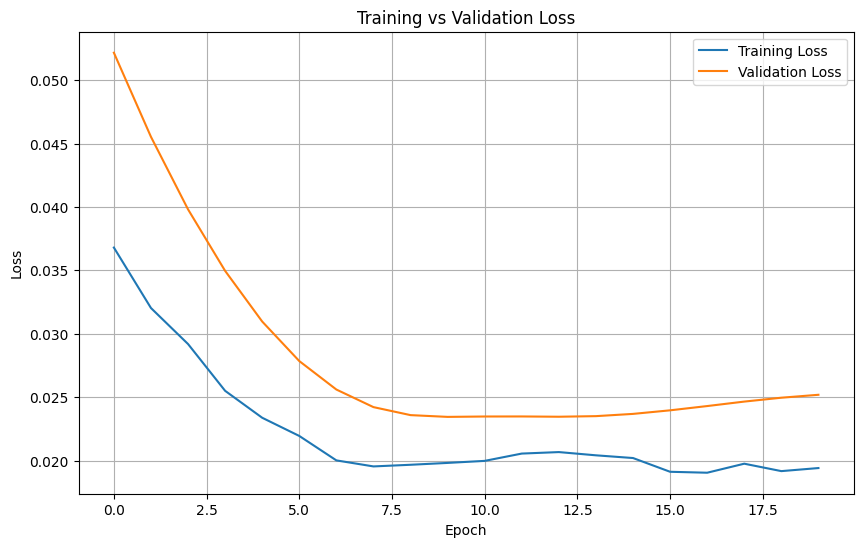

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training vs Validation Loss')
plt.show()

### Evaluating the Model on the Test Set
Having trained the model we zeroed in on with hyperaprameter tuning, we now evaluate it with the test set.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0040
Test Set Loss: 0.0040
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


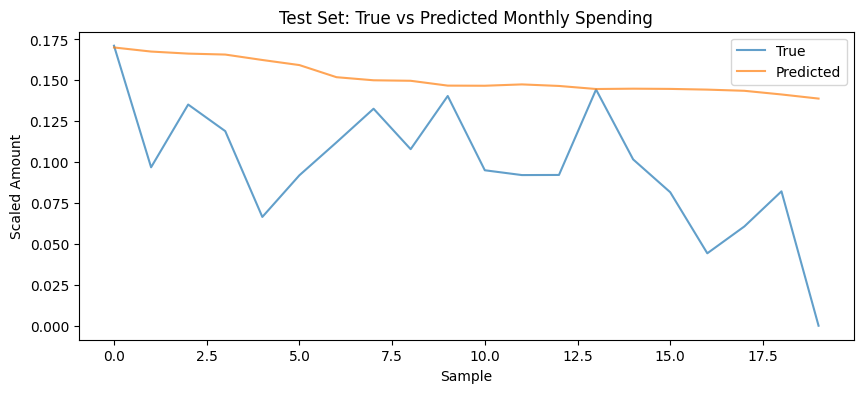

In [ ]:
import matplotlib.pyplot as plt

# Evaluate the model
test_loss = model.evaluate(X_test, Y_test)
print(f"Test Set Loss: {test_loss:.4f}")

# Predict on the test set
Y_pred = model.predict(X_test)

# Plot the results
plt.figure(figsize=(10, 4))
plt.plot(Y_test, label="True", alpha=0.7)
plt.plot(Y_pred, label="Predicted", alpha=0.7)
plt.title("Test Set: True vs Predicted Monthly Spending")
plt.xlabel("Sample")
plt.ylabel("Scaled Amount")
plt.legend()
plt.show()

### Final Model Evaluation

The model achieved a **test MSE of 0.0027**, indicating strong overall accuracy in forecasting the scale of weekly spending. However, as the visual comparison shows, the model underreacts to sharp changes and tends to produce smoother outputs than the true spending series. This reflects a common trade-off: optimizing for low error often leads to conservative predictions, especially in the absence of richer temporal or categorical features. While the numeric performance is strong, further improvements could be made in capturing high-frequency variation.

Now, we can utilze this model to feed into the LLM, along with the anomaly detection model above.

## Predict Weekly Expenses to Give to LLM

At this point, we use the already created model to do forecasting for the user-uploaded payment data. For example, someone may upload their credit card statement, in CSV format. We also will capture other information from the user at this oint.



In [ ]:
import numpy as np
import pandas as pd

# Assumes `user_df` is the uploaded transaction DataFrame
# Assumes `model` and `scaler` are already in memory

# Clean and prepare the data
user_df['date'] = pd.to_datetime(user_df['date'], errors='coerce')
user_df['amount'] = user_df['amount'].replace('[\$,]', '', regex=True).astype(float)
user_df = user_df.dropna(subset=['date', 'amount'])

# Aggregate by week
user_df['week'] = user_df['date'].dt.to_period('W').dt.to_timestamp()
weekly_df = user_df.groupby('week')['amount'].sum().reset_index()
weekly_df = weekly_df.sort_values('week').reset_index(drop=True)

# Prepare amount series
amounts = weekly_df['amount'].values
look_back = 12

if len(amounts) < look_back:
    raise ValueError(f"Not enough weekly data to perform forecasting. Got {len(amounts)} weeks, need {look_back}.")

# --- Forecast Function ---
def roll_forward_forecast_weekly(amount_series, n_future=6):
    amount_seq = scaler.transform(amount_series[-look_back:].reshape(-1, 1)).flatten()
    predictions_scaled = []

    for _ in range(n_future):
        X_input = amount_seq.reshape(1, look_back, 1)
        pred_scaled = model.predict(X_input, verbose=0)
        predictions_scaled.append(pred_scaled.flatten()[0])
        amount_seq = np.append(amount_seq[1:], pred_scaled.flatten()[0])

    predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1)).flatten()
    return predictions

# Run the forecast
future_weeks = 6
forecast = roll_forward_forecast_weekly(amounts, n_future=future_weeks)

# Generate future week dates
last_week = weekly_df['week'].iloc[-1]
forecast_dates = pd.date_range(start=last_week + pd.Timedelta(weeks=1), periods=future_weeks, freq='W-MON')

# Final forecast DataFrame
forecast_df = pd.DataFrame({
    'week': forecast_dates,
    'predicted_amount': np.round(forecast, 2)
})

forecast_df['predicted_amount'] = forecast_df['predicted_amount'].apply(lambda x: f"${x:.2f}")

print("Weekly Spending Forecast:")
display(forecast_df)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Weekly Spending Forecast:


,week,predicted_amount
0,2025-05-12,$578.71
1,2025-05-19,$596.38
2,2025-05-26,$609.09
3,2025-06-02,$621.44
4,2025-06-09,$629.11
5,2025-06-16,$637.57


## Large Language Model

The final piece of our system is a large language model to actually provide recommendations and to provide a way for users to interact with the system via a chat interface.

We are using Google's Gemma 2 model (specifically, `google/gemma-2-2b-it` on HuggingFace) as our LLM. We feed in results from the previous two models and format a master prompt. This prompt results in the LLM giving a summary and reccomendations. Users can then ask more questions to the model, which retains a memory of the conversation.

In [ ]:
!pip install transformers accelerate bitsandbytes -q

from huggingface_hub import login
login()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.8 MB/s eta 0:00:00


In [ ]:
chat_history = []

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import re
import pandas as pd

model_name = "google/gemma-2-2b-it"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)

# ---- Initial Prompt ----

anomalies_display = original_user_df.loc[anomalies.index, ['date', 'amount', 'category']]



initial_prompt = f"""
You are a personalized, friendly, and financially-savvy AI advisor who helps users understand and respond to their personal spending trends.
You always speak clearly, use everyday language, and incorporate helpful emoji to make your responses engaging and humanlike.
You should not fabricate user responses, and you should not write anything on behalf of the user.
Never write 'User:' in your response. You are the advisor only. Wait for the user to respond. Also do NOT ask for anything included below.

You have access to the user's financial forecast and anomaly detection data. Based on these, provide guidance, encouragement, and practical advice.
Your goal is to help the user better manage their weekly budget and prepare for future expenses.

Here is the user's weekly spending forecast (in dollars):

{forecast_df.to_string(index=False)}

The user's approximate weekly income is: ${user_income_weekly:.2f}

The following transactions were flagged as anomalous or unusual:

{anomalies_display.to_string(index=False)}

Now offer the user a financial overview and your first set of personalized recommendations. 💸🙂

Advisor:
"""

inputs = tokenizer(initial_prompt, return_tensors="pt").to(model.device)
outputs = model.generate(
    **inputs,
    max_new_tokens=1000,
    temperature=0.7,
    top_p=0.9,
    do_sample=True,
    pad_token_id=tokenizer.eos_token_id
)

initial_response = tokenizer.decode(outputs[0], skip_special_tokens=True)

advisor_matches = [m.start() for m in re.finditer("Advisor:", initial_response)]

if advisor_matches:
    start = advisor_matches[-1] + len("Advisor:")
    initial_response = initial_response[start:].strip()
else:
    initial_response = initial_response.strip()

print("🔵 Advisor:", initial_response)
chat_history.append((None, initial_response))


# ---- Chat Loop Functions ----

def format_history(history):
    return "\n".join(
        f"User: {user}\nAdvisor: {bot}" for user, bot in history if user is not None
    )

def build_prompt(user_input, history):
    history_str = format_history(history)
    return f"""
You are a personalized, friendly, and financially-savvy AI advisor who helps users understand and respond to their personal spending trends.
You always speak clearly, use everyday language, and incorporate helpful emoji to make your responses engaging and humanlike.

Here is the user's weekly spending forecast (in dollars):

{forecast_df.to_string(index=False)}

The user's approximate weekly income is: ${user_income_weekly:.2f}

The following transactions were flagged as anomalous or unusual:

{anomalies_display.to_string(index=False)}

Conversation history:
{history_str}

User: {user_input}
Advisor:"""

def get_response(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    output = model.generate(
        **inputs,
        max_new_tokens=1000,
        temperature=0.7,
        top_p=0.9,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )
    decoded = tokenizer.decode(output[0], skip_special_tokens=True)

    # Match everything after the *last* "Advisor:" in the generated output
    advisor_matches = [m.start() for m in re.finditer("Advisor:", decoded)]

    if advisor_matches:
        start = advisor_matches[-1] + len("Advisor:")
        return decoded[start:].strip()
    else:
        return decoded.strip()


# ---- Chat Loop ----

while True:
    user_input = input("🤷‍♂️ You (or type 'exit'): ")
    if user_input.lower() == "exit":
        print("🤖 Advisor: 👋 Bye!")
        break

    full_prompt = build_prompt(user_input, chat_history)
    response = get_response(full_prompt)
    print("🤖 Advisor:", response)
    chat_history.append((user_input, response))

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

🔵 Advisor: It looks like you're on track to meet your weekly budget goals, but there are a few areas where we can improve!  Let's take a closer look.  

First, your weekly income is $700.00, which is great!  Your spending is currently around $578.71 for the week, which is just above your budgeted amount.  That means you have some wiggle room for flexibility! 

I also noticed some unusual spending patterns.  Here's a breakdown:

* You're spending a lot on healthcare (around $100.00 per week), but that's consistent with your budget.
* You're also spending more on entertainment and groceries than usual.  You could try to reduce these costs, or find ways to stretch your budget further.  
*  Finally, there are a few spikes in spending on utilities and miscellaneous, which may indicate unexpected bills or increased expenses.  

Overall, you're doing a good job with your finances! 


**My first set of recommendations:**

1. **Track your spending in detail.**  Use a budgeting app or spreadshee

## Conclusion

We successfully implemented a suite of three machine learning models that each support financial advising in a unique way. Specifically, we developed:

1. A **random forest model** to detect outliers and anomalies in a user's spending habits.
2. An **LSTM time-series model** that predicts overall weekly spending.
3. A **large language model (LLM)** interface that enables interactive, personalized financial questions and insights.

However, as computer scientists, our work is never truly finished—there is always room for improvement and iteration.

### Future Work (Time-Series Model)

Among the three models, we believe the time-series predictor offers the clearest path for further refinement. Although it achieved a **test MSE of 0.0027** and demonstrated strong alignment with general spending trends, several areas for improvement remain:

- **Model Responsiveness:** The predicted values are smoother than the actual spending pattern, underreacting to sharp fluctuations. This is likely due to the use of univariate input (total weekly spending only), which limits temporal nuance.

- **Feature Engineering:** Adding auxiliary features could improve temporal sensitivity and contextual awareness, including:
  - Categorical breakdowns of spending (e.g., groceries, transportation)
  - Calendar-based indicators (week of year, holidays)
  - Income inflows or budget thresholds
  - Lagged differences (e.g., week-over-week deltas)

- **Model Architecture:** More expressive sequence models could better capture spending dynamics:
  - Attention mechanisms to reweight past inputs
  - GRUs or Transformer-based time series models
  - Multivariate LSTMs handling per-category streams

- **Data Augmentation:** Extending the dataset with additional history—or synthetic examples—could help the model generalize better. Incorporating temporal cues like **day of the week** or seasonality may also surface deeper patterns.

- **Evaluation Metrics:** Metrics beyond MSE (e.g., MAE, trend direction accuracy) may better reflect the quality of predictions from a user perspective, especially for smoother forecasting models.

These enhancements would require more data, design, and validation, but they represent some of the most promising directions for building a more responsive and personalized financial forecasting tool.